# 基于DDPG算法的电磁式阻尼器控制

本笔记本实现了基于DDPG算法的二自由度电磁阻尼器控制系统。参数来源于MATLAB仿真文件，方法迁移自《数据驱动的动力学系统建模及控制策略研究》。

### 导入外部依赖

In [7]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path

### 编程环境搭建

In [8]:
train_model = True  # 训练模式开关

import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison, plot_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


## 超参数设置

In [9]:
# 仿真环境设置
T = 5
Ts = 0.002
tolerance = 2e-6 # 误差容忍度
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5.0 # 动作范围
actor_lr=1e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.02 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=64 # 批量大小
# 训练超参数
n_episodes = 200 # 训练轮数
min_buffer_size = int(5e3) # 最小经验池大小
print_interval = 4 # 打印间隔
save_interval = 5 # 保存间隔

### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [10]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000.0  # 电磁吸振器刚度
k_M = 200000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 0.2  # 电磁吸振器阻尼
c_M = 1.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.zeros((2, 1))

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

### 无控制输出环境验证

仿真进度: 10001it [00:00, 21484.51it/s]                          


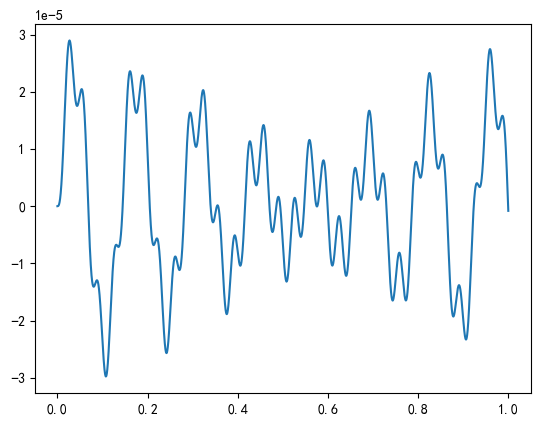

In [11]:
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.0001, T=1)

# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=sine_disturbance(0.0001, 30))
plt.plot(results_no_control['times'], results_no_control['all_states'][:, 3], label='No Control')

## 训练DDPG代理

### 初始化环境和DDPG代理

In [12]:
# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [2,5]  # 观测状态索引

# 定义正弦扰动函数
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func
z_func=sine_disturbance(0.001, 30)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

# 定义奖励函数
def r_func(obs:np.ndarray, action:np.ndarray, next_obs:np.ndarray)-> float:
    """基于误差容限的奖励函数\n
    需要保证输入观测值只有一个维度"""
    obs = obs.tolist()
    next_obs = next_obs.tolist() # 将张量转换为列表
    x1, v1, a1 = obs[:3]
    x2, v2, a2 = obs[3:6]
    next_x1, next_v1, next_a1 = next_obs[:3]
    next_x2, next_v2, next_a2 = next_obs[3:6]
    
    if (abs(next_x2) < tolerance) and (abs(next_x2) < abs(x2)):
        # 处于容忍范围内或下一个状态更接近容忍范围
        reward = abs(tolerance - abs(next_x2)) / tolerance
    elif (abs(next_x2) > tolerance) and (abs(next_x2) > abs(x2)):
        # 处于容忍范围外或下一个状态更远离容忍范围
            reward = -0.5 
    else:
        reward = -0.1
    return reward

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

# 创建仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, z_func=z_func, obs_indices=observation_indices,r_func=r_func)

# 创建DDPG智能体
agent = DDPGAgent(
    state_dim = len(observation_indices), # 状态维度
    hidden_dim=hidden_dim, # 隐藏层维度
    action_bound=action_bound, # 动作范围
    actor_lr=actor_lr, # Actor学习率
    critic_lr=critic_lr, # Critic学习率
    gamma=gamma, # 折扣因子
    tau=tau, # 软更新参数
    sigma=sigma, # 初始噪声标准差
    clip_grad=clip_grad, # 是否裁剪梯度
)

# 创建经验回放池
replay_buffer = ReplayBuffer(capacity=capacity, batch_size=batch_size)

### 记录日志

In [13]:
if train_model:
    logging.info(f"开始训练的时间: {datetime.now()}")  # 记录训练开始时间
    paras_info = {
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "隐藏层维度": hidden_dim,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"训练参数：{json.dumps(paras_info, indent=4, ensure_ascii=False)}")  # 记录训练参数
    
    logging.info(f"Actor网络架构:{agent.actor}")  # 记录Actor网络架构
    logging.info(f"Critic网络架构:{agent.critic}")  # 记录Critic网络架构
    
    start_episode,initial_episode_rewards = load_checkpoint(agent=agent, save_dir=os.path.join(save_dir, f"checkpoints")) # 加载检查点

    logging.info(f"开始训练的轮数: {start_episode}")

### 训练DDPG代理

In [14]:
if train_model:# 训练DDPG代理
    try:
        training_results = train_ddpg(
            env=rl_env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=n_episodes, # 训练轮数
            min_buffer_size=min_buffer_size, # 最小经验池大小
            print_interval=print_interval, # 打印间隔
            save_interval=save_interval, # 保存间隔
            save_path=save_checkpoint_path, # 保存训练信息的路径
            start_episode=start_episode,
            initial_episode_rewards=initial_episode_rewards,
        )
    except KeyboardInterrupt:
        logging.info("训练中断，保存当前模型...")
        agent.save_model(save_path=save_checkpoint_path, episode=n_episodes)
        logging.info("模型已保存。")
    except Exception as e:
        logging.error(f"训练过程中发生错误: {e}")
        raise e

    logging.info(f"训练完成，最终平均奖励: {training_results['avg_rewards'][-1]:.2f}")

训练轮次:   2%|▏         | 4/200 [00:51<54:30, 16.69s/it]

Episode:    4, Reward: -759.06, Avg Reward: -751.48, Avg Critic Loss: 0.0904, Avg Actor Loss: 0.4439, Epsilon: 0.97


训练轮次:   2%|▎         | 5/200 [01:17<1:05:00, 20.00s/it]

已保存模型数据: 0519_2323_ep5_checkpoint.pth


训练轮次:   2%|▎         | 5/200 [01:18<50:59, 15.69s/it]  


AttributeError: 'DDPGAgent' object has no attribute 'save_model'

## 绘图验证

### 加载模型和数据

In [ ]:
if train_model is not True:
    # 加载检查点
    _, episode_rewards = load_checkpoint(agent=agent, save_dir=save_checkpoint_path)
else:
    episode_rewards = training_results['episode_rewards']
    avg_rewards = training_results['avg_rewards']

### 绘制训练奖励曲线

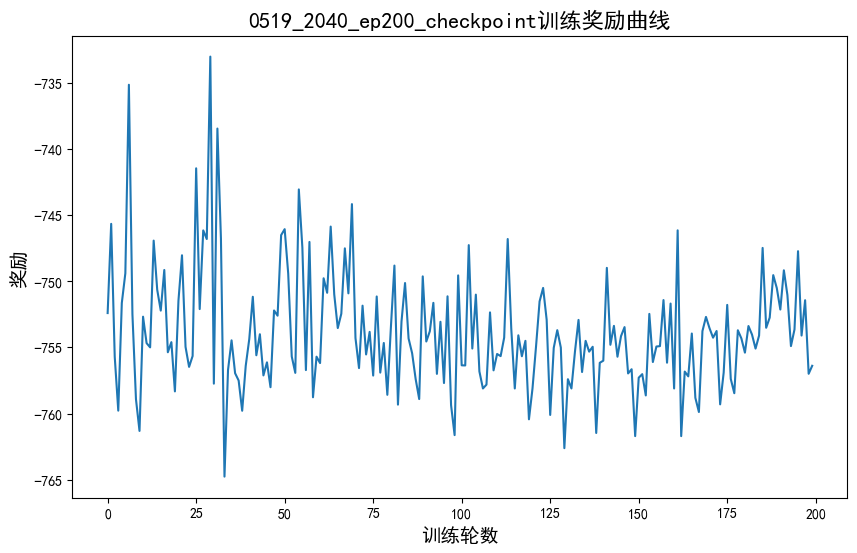

In [ ]:
plot_data(plot_title=f"{agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[episode_rewards],
          save_path=save_plot_path)
logging.info(f"奖励图表已保存: {save_plot_path}")

### 测试模型

仿真进度: 2501it [00:00, 15840.35it/s]                          
仿真进度: 2501it [00:02, 1047.73it/s]                          


-754.254565084528


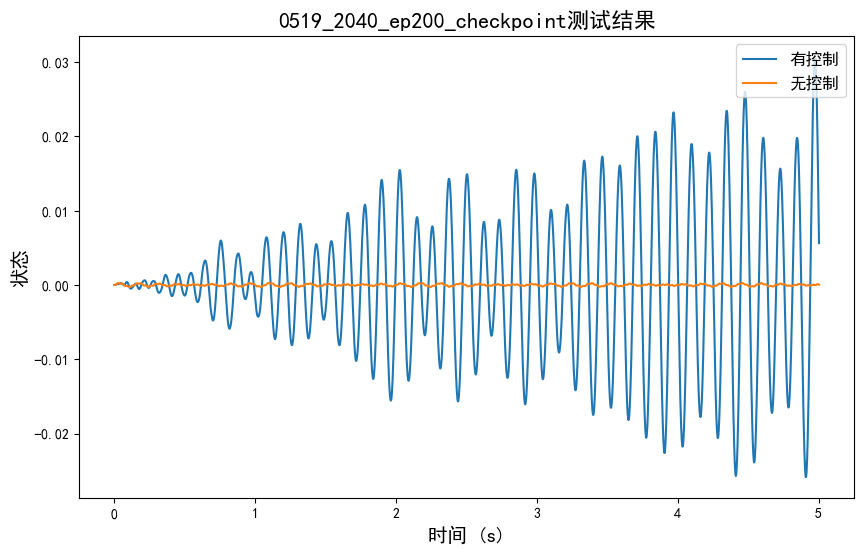

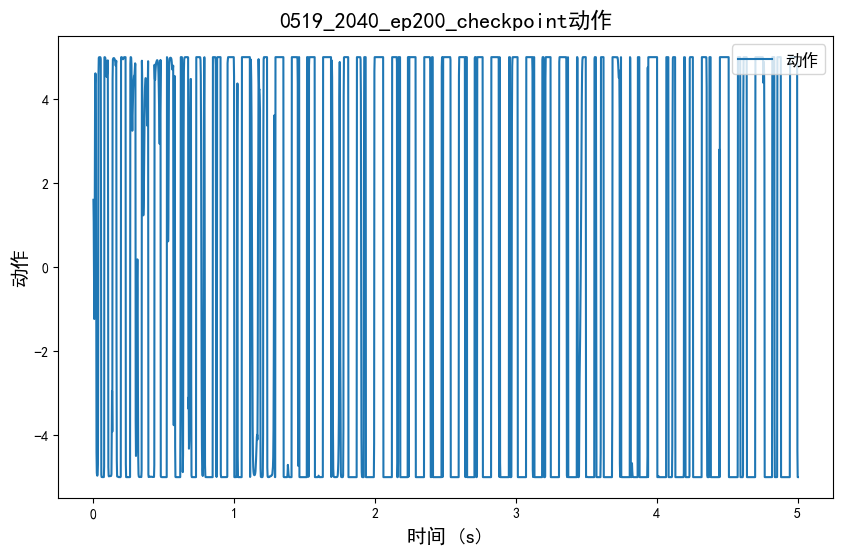

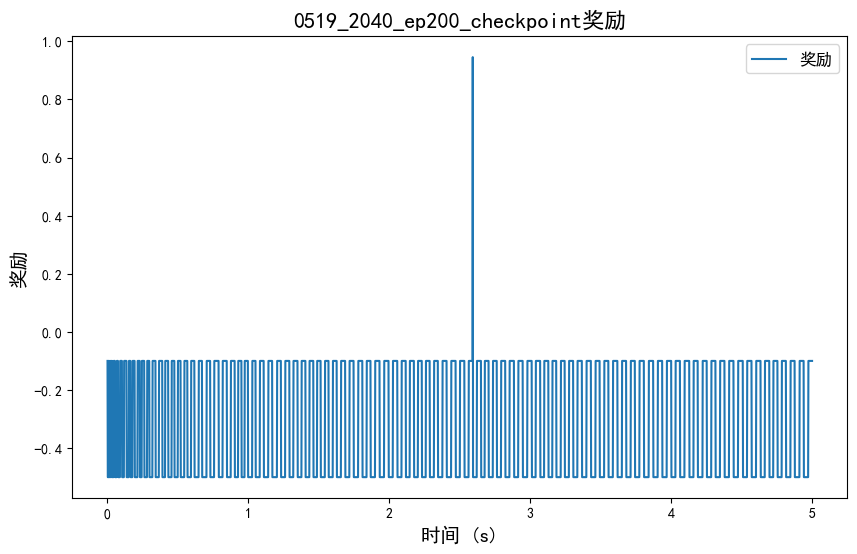

In [ ]:
# 运行测试
results_nc = rl_env.run_simulation(z_func=sine_disturbance(0.001, 30), r_func=r_func)
results_ddpg = rl_env.run_simulation(controller=agent, z_func=sine_disturbance(0.001, 30))
print(np.sum(results_ddpg['rewards']))

plot_data(plot_title=f"{agent.model_name}测试结果",
          xlabel="时间 (s)",
          ylabel="状态",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['all_states'][:, 3], results_nc['all_states'][:, 3]],
          save_path=save_plot_path,
          legends=["有控制", "无控制"]
          )

plot_data(plot_title=f"{agent.model_name}动作",
          xlabel="时间 (s)",
          ylabel="动作",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['actions']],
          save_path=save_plot_path,
          legends=["动作"]
          )

plot_data(plot_title=f"{agent.model_name}奖励",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['rewards']],
          save_path=save_plot_path,
          legends=["奖励"]
          )